In [1]:
%run /home/analysis_user/New_trap_code/Tools/basic_packages.py
sys.path.append('/home/analysis_user/New_trap_code/SensitivityFramework/')
from signal_model_utilities_v3 import *
from shutil import copyfile

plt.rcParams["figure.figsize"] = (16,12)
plt.rcParams["font.size"] = 24
plt.rcParams['xtick.labelsize'] = "small"
plt.rcParams['ytick.labelsize'] = 36

In [2]:
def repeat(arr, count):
    z_sig = []
    for i in range(count):
        z_sig.extend(arr)
    return z_sig


In [3]:
def mock_injection_signal(alpha_scale,lambda_val,height_sep=-15.5,x_sep=13.9,offset_y=+4.9,phase_shift="TF"):
    stroke=-202
    frequency=3
    axis="z"
    yuk_or_grav="yuk"
    alpha=1
    bead_size=7.6
    signal_sim = force_vs_time(x_sep,height_sep,stroke,frequency,axis,lambda_val,offset_y,yuk_or_grav,alpha,bead_size)
    
    # shift phase of signal according to TF
        # data from Nadav's google doc [https://docs.google.com/spreadsheets/d/132wBYgWQt44M5gDtw48kFwvLDv416yS83ISfGujQUt4/edit#gid=0]

    # convert to bits, this works only for one second chunk!
        # data from Nadav's google doc [https://docs.google.com/spreadsheets/d/132wBYgWQt44M5gDtw48kFwvLDv416yS83ISfGujQUt4/edit#gid=0]

    TF_phases = [1.22,0.97,0.65,0.49,0.3,0.12,0.29,0.13,0.23,0.22,0.27,0.27,0.07]    
    if(phase_shift=="TF"):TF_phase_shift = TF_phases
    elif(phase_shift=="Flip"):TF_phase_shift = [-1*element for element in TF_phases] # this flips
    elif(phase_shift=="Random_TF"):TF_phase_shift = [1*np.random.normal(element,element/20) for element in TF_phases]
    elif(phase_shift=="Random"):TF_phase_shift =  np.random.uniform(-np.pi,np.pi,len(TF_phases))
    else:TF_phase_shift = len(TF_phases)*[0]
    print(TF_phase_shift)
    harmonics = np.arange(3,len(TF_phases)*3+3,3)

    #print(len(TF_phase_shift))
    # 6 charges new
    amplitude_scale = [2.40E-17,1.35E-17,1.05E-17,9.78E-18,9.45E-18,9.81E-18,9.82E-18,1.04E-17,9.92E-18,7.50E-18,8.37E-18,7.10E-18,7.84E-18]

    fft_sim = np.fft.rfft(signal_sim[1]) 
    new_fft_sim = fft_sim.copy()
    new_fft_shift_only = fft_sim.copy()
    #new_fft_sim[0]=1/np.mean(amplitude_scale) * np.abs(fft_sim[0]) # not necessary?
    for harmonic in harmonics:
        new_fft_shift_only[harmonic] = np.abs(fft_sim[harmonic])*np.exp(1j*(np.angle(fft_sim[harmonic])+TF_phase_shift[harmonic//3-1]))
        new_fft_sim[harmonic] = 1/amplitude_scale[harmonic//3-1] * np.abs(fft_sim[harmonic])*np.exp(1j*(np.angle(fft_sim[harmonic])+TF_phase_shift[harmonic//3-1]))

    signal_sim_shift=np.fft.irfft(new_fft_shift_only) 
    signal_sim_shift_scale =np.fft.irfft(new_fft_sim) 
    
    
    # extend to 10s
    z_sig = repeat(signal_sim_shift_scale,10)
    # scale to desired alpha
    z_sig_10 = np.multiply(z_sig,alpha_scale)
    
    return z_sig_10,TF_phase_shift,amplitude_scale

In [4]:
def mock_injection_bkg(alpha_scale_bkg,lambda_val,height_sep=-15.5,x_sep=13.9,offset_y=+4.9,TF_phases_bkg = [1.22,0.97,0.65,0.49,0.3,0.12,0.29,0.13,0.23,0.22,0.27,0.27,0.07]):
    stroke=-202
    frequency=3
    axis="z"
    yuk_or_grav="yuk"
    alpha=1
    bead_size=7.6
    background_sim = force_vs_time(x_sep,height_sep,stroke,frequency,axis,lambda_val,offset_y,yuk_or_grav,alpha,bead_size)
    
    # shift phase of signal according to TF
        # data from Nadav's google doc [https://docs.google.com/spreadsheets/d/132wBYgWQt44M5gDtw48kFwvLDv416yS83ISfGujQUt4/edit#gid=0]

    # convert to bits, this works only for one second chunk!
        # data from Nadav's google doc [https://docs.google.com/spreadsheets/d/132wBYgWQt44M5gDtw48kFwvLDv416yS83ISfGujQUt4/edit#gid=0]
    harmonics = np.arange(3,len(TF_phases_bkg)*3+3,3)

    #print(len(TF_phase_shift))
    # 6 charges new
    
    #alpha_scale_bkg = [1/1]*len(TF_phases)#/1e10
    TF_amp_scale = [2.40E-17,1.35E-17,1.05E-17,9.78E-18,9.45E-18,9.81E-18,9.82E-18,1.04E-17,9.92E-18,7.50E-18,8.37E-18,7.10E-18,7.84E-18]
    amplitude_scale = np.multiply(TF_amp_scale,alpha_scale_bkg)
    fft_sim_bkg = np.fft.rfft(background_sim[1]) 
        
    new_fft_sim_bkg = fft_sim_bkg.copy()
    #new_fft_sim_bkg[0]=1/np.mean(amplitude_scale) * np.abs(fft_sim_bkg[0]) # not necessary?
    #print(np.abs(fft_sim_bkg[0]),1/np.mean(amplitude_scale),np.abs(new_fft_sim_bkg[0]))

    for harmonic in harmonics:
        new_fft_sim_bkg[harmonic] = 1/amplitude_scale[harmonic//3-1]*(np.abs(fft_sim_bkg[harmonic])) *np.exp(1j*(np.angle(fft_sim_bkg[harmonic])+TF_phases_bkg[harmonic//3-1]))

    signal_sim_bkg =np.fft.irfft(new_fft_sim_bkg) 
    
    
    # extend to 10s
    z_bkg = repeat(signal_sim_bkg,10)
    # scale to desired alpha - not used anymore
    z_bkg_10 = np.multiply(z_bkg,1)
    
    return z_bkg_10,TF_phases_bkg,amplitude_scale,alpha_scale_bkg

In [5]:
def file_creator_rounding_uniform_random_noise(final_signal,in_file_paths,out_dir,direction,run_no,max_file=1000):
    i=0
    out_dirs=  out_dir+"/%d/" %run_no
    try: os.makedirs(out_dirs)
    except: print("Did not create %s. It may exist or you do not have perimissions." %out_dir)    

    for file_path in in_file_paths:
        #print(file_path)
        i+=1
        if(i<(max_file+1)):
            #if (i % 10==0):print("%f percent" %(i/max_file*100))
            with h5py.File(file_path, 'r') as f_in:
                quad_data_in = np.array(f_in['quad_data'])
                data_in = quad_data_in.reshape(-1,12).T[9]
                #plt.plot(np.array(data_in))
                random_uni =np.random.uniform(-0.5,0.5,len(data_in)) # make a list of random numbers between -0.5 and 0.5
                new_data_uni = data_in + random_uni# add them                 
                if(direction=="push"): z_sn = np.subtract(np.array(new_data_uni),np.array(final_signal))
                elif(direction=="pull"): z_sn = np.add(np.array(new_data_uni),np.array(final_signal))
                else: print("Force has to go either way")
                
                z_sn_round = [round(element) for element in z_sn] # round to half even

                    
                quad_data_in.reshape(-1,12).T[9] = z_sn_round
                f_in.close()
                #plt.plot(np.array(z_sn),color="black")
            out_path = out_dirs + "Noise_batch_%d.h5" %(i-1)
            copyfile(src=file_path, dst=out_path)
            with h5py.File(out_path, 'r+') as f_out:
                del f_out['quad_data']
                f_out.create_dataset("quad_data", quad_data_in.shape,data=quad_data_in)
                f_out.close()
    return print("Done")

In [9]:
def metafile_creator(x):
    f = open(out_dir+"run_%d.txt" %x, "w")
    f.write("Run number: %d\n alpha value: %f \n lambda value: %f \n direction: %s \n %s %s \n Amplitude scale %s" %(run_no[x],alpha_scale_in[x],lambda_val_in[x],direction_in[x],phase_shift_in[x],str(TF_phase_shift),str(amplitude_scale)))
    f.close()
    return

In [10]:
def metafile_creator_bkg(x):
    f = open(out_dir+"run_%d.txt" %x, "w")
    f.write("Run number: %d\n alpha value bkg: %s \n TF_phases_bkg: %s " %(run_no[x],alpha_scale_bkg,TF_phases_bkg))
    f.close()
    return

In [23]:
in_dir = r"/data/new_trap_processed/mockfiles/20200320/raw/noise/"
out_dir = r"/data/new_trap_processed/mockfiles/20200320/output/noise/non_blind_with_bkg/Test9/"

in_file_paths = []
for file_path in glob.iglob(in_dir+"*.h5"):
    in_file_paths.append(file_path)



In [24]:
no= 20
# make lists
alpha_scale_in = [np.random.randint(2,3)*1e8 for x in range(no)]
lambda_val_in = [20]*no
direction_in = no*["pull"]
phase_shift_in = no*["TF"]
alpha_scale_bkg = [1/(np.random.randint(5,50)*1e1)]*13
TF_phases_bkg = [1.22,0.97,0.65,0.49,0.3,0.12,0.29,0.13,0.23,0.22,0.27,0.27,0.07] 

Loading Gravity Data... Done!
81 9.74070978211e-06
Loaded Yukawa Force
[1.22, 0.97, 0.65, 0.49, 0.3, 0.12, 0.29, 0.13, 0.23, 0.22, 0.27, 0.27, 0.07]
Loading Gravity Data... Done!
81 9.74070978211e-06
Loaded Yukawa Force


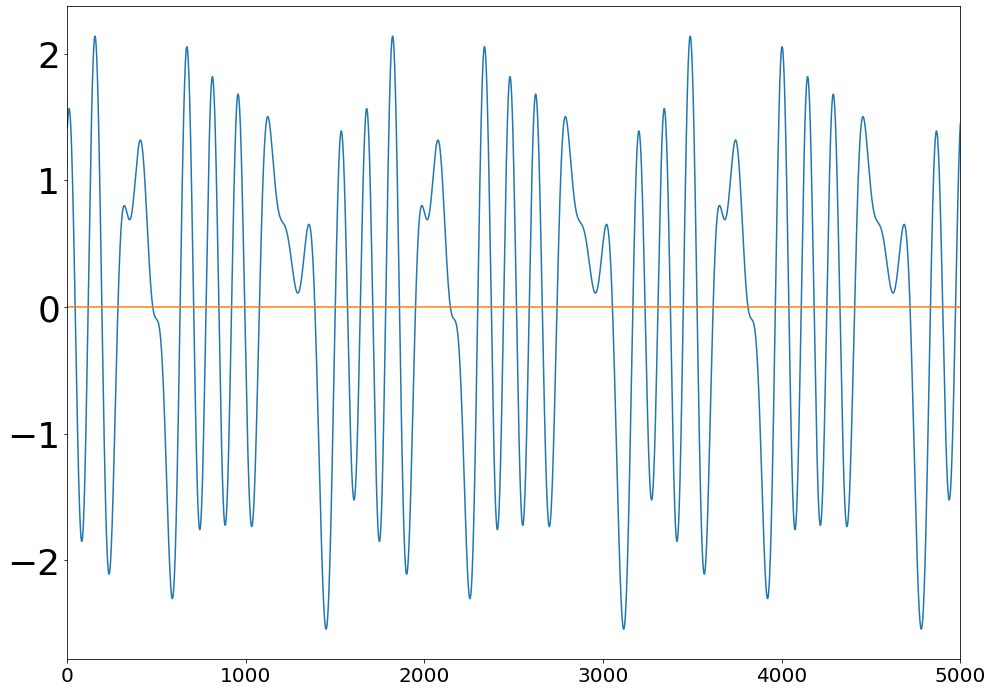

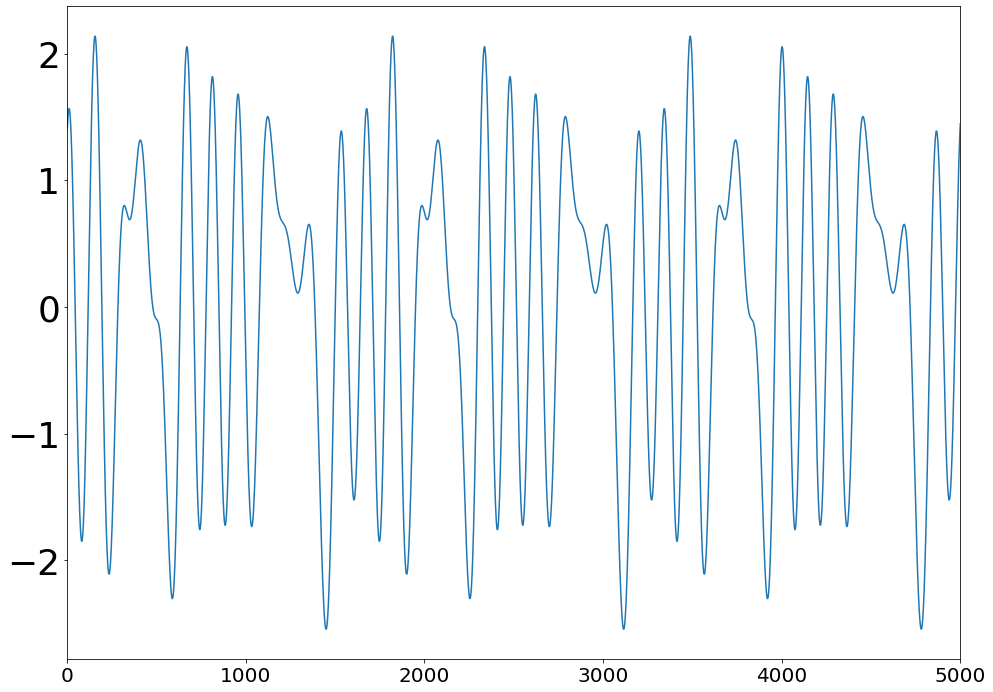

In [25]:
z_sig_10,tps_s,as_s = mock_injection_signal(2e8,lambda_val=10,height_sep=-15.5,x_sep=13.9,offset_y=+4.9,phase_shift="TF")
z_bkg_10,tps_b,as_b,ap_b = mock_injection_bkg(alpha_scale_bkg=alpha_scale_bkg,lambda_val=10,height_sep=-15.5,x_sep=13.9,offset_y=+4.9,TF_phases_bkg = TF_phases_bkg)
plt.plot(z_sig_10)
plt.plot(z_bkg_10)
plt.xlim(0,5000)
plt.show()
final_signal = z_sig_10+z_bkg_10
plt.plot(final_signal)
plt.xlim(0,5000)
plt.show()

Loading Gravity Data... 


  0%|          | 0/1 [00:00<?, ?it/s]

Done!
81 9.74070978211e-06
Loaded Yukawa Force
[1.22, 0.97, 0.65, 0.49, 0.3, 0.12, 0.29, 0.13, 0.23, 0.22, 0.27, 0.27, 0.07]
Loading Gravity Data... Done!
81 9.74070978211e-06
Loaded Yukawa Force
Did not create /data/new_trap_processed/mockfiles/20200320/output/noise/non_blind_with_bkg/testforalex/bkg2/. It may exist or you do not have perimissions.



100%|██████████| 1/1 [01:22<00:00, 82.85s/it]

Done


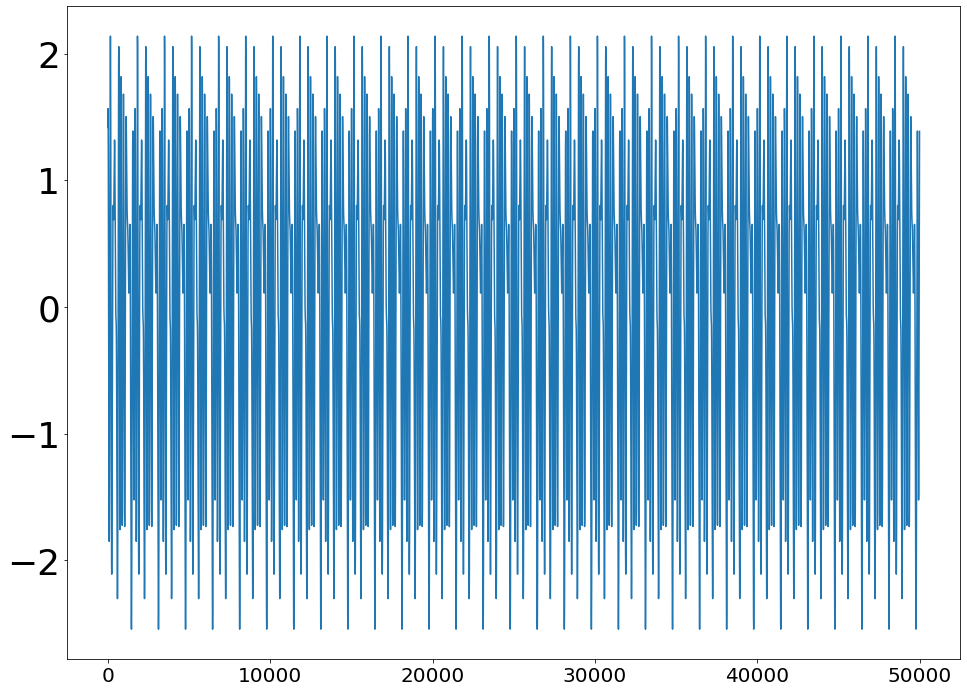

In [21]:
run_no =np.arange(0,no,1)
#np.random.shuffle(run_no)
a_b_l =[]
z_sig_10,tps_s,as_s = mock_injection_signal(2e8,lambda_val=10,height_sep=-15.5,x_sep=13.9,offset_y=+4.9,phase_shift="TF")

for i in tqdm(range(1)):
    alpha_scale_bkg = [1/0.1]*13
    TF_phases_bkg = [1.22,0.97,0.65,0.49,0.3,0.12,0.29,0.13,0.23,0.22,0.27,0.27,0.07] 
    z_bkg_10,tps_b,as_b,ap_b = mock_injection_bkg(alpha_scale_bkg=alpha_scale_bkg,lambda_val=10,height_sep=-15.5,x_sep=13.9,offset_y=+4.9,TF_phases_bkg = TF_phases_bkg)
    final_signal = z_sig_10 + z_bkg_10  
    plt.plot(final_signal)
    file_creator_rounding_uniform_random_noise(final_signal,in_file_paths,out_dir,direction=direction_in[i],run_no=run_no[i],max_file=1000)
    #metafile_creator(i)
    metafile_creator_bkg(i)
    a_b_l.append(alpha_scale_bkg)
np.save(out_dir+"run_no.npy",run_no)
#np.save(out_dir+"alpha_scale_in.npy",alpha_scale_in)
np.save(out_dir+"lambda_val_in.npy",lambda_val_in)
np.save(out_dir+"direction_in.npy",direction_in)
np.save(out_dir+"phase_shift_in.npy",phase_shift_in)
np.save(out_dir+"alpha_scale_bkg.npy",a_b_l)


Loading Gravity Data... 


  0%|          | 0/20 [00:00<?, ?it/s]

Done!
81 9.74070978211e-06
Loaded Yukawa Force
[1.22, 0.97, 0.65, 0.49, 0.3, 0.12, 0.29, 0.13, 0.23, 0.22, 0.27, 0.27, 0.07]
0 0
Loading Gravity Data... Done!
81 9.74070978211e-06
Loaded Yukawa Force



  5%|▌         | 1/20 [03:02<57:49, 182.62s/it]

Done
1 1
Loading Gravity Data... Done!
81 9.74070978211e-06
Loaded Yukawa Force



 10%|█         | 2/20 [04:35<46:40, 155.57s/it]

Done
2 2
Loading Gravity Data... Done!
81 9.74070978211e-06
Loaded Yukawa Force



 15%|█▌        | 3/20 [05:56<37:45, 133.29s/it]

Done
3 3
Loading Gravity Data... Done!
81 9.74070978211e-06
Loaded Yukawa Force



 20%|██        | 4/20 [07:17<31:21, 117.57s/it]

Done
4 4
Loading Gravity Data... Done!
81 9.74070978211e-06
Loaded Yukawa Force



 25%|██▌       | 5/20 [08:44<27:05, 108.36s/it]

Done
5 5
Loading Gravity Data... Done!
81 9.74070978211e-06
Loaded Yukawa Force



 30%|███       | 6/20 [10:11<23:48, 102.05s/it]

Done
6 6
Loading Gravity Data... Done!
81 9.74070978211e-06
Loaded Yukawa Force



 35%|███▌      | 7/20 [11:45<21:36, 99.76s/it] 

Done
7 7
Loading Gravity Data... Done!
81 9.74070978211e-06
Loaded Yukawa Force



 40%|████      | 8/20 [13:33<20:26, 102.22s/it]

Done
8 8
Loading Gravity Data... Done!
81 9.74070978211e-06
Loaded Yukawa Force



 45%|████▌     | 9/20 [14:56<17:39, 96.35s/it] 

Done
9 9
Loading Gravity Data... Done!
81 9.74070978211e-06
Loaded Yukawa Force



 50%|█████     | 10/20 [16:20<15:25, 92.50s/it]

Done
10 10
Loading Gravity Data... Done!
81 9.74070978211e-06
Loaded Yukawa Force



 55%|█████▌    | 11/20 [17:43<13:29, 89.90s/it]

Done
11 11
Loading Gravity Data... Done!
81 9.74070978211e-06
Loaded Yukawa Force



 60%|██████    | 12/20 [19:15<12:02, 90.34s/it]

Done
12 12
Loading Gravity Data... Done!
81 9.74070978211e-06
Loaded Yukawa Force



 65%|██████▌   | 13/20 [20:38<10:18, 88.35s/it]

Done
13 13
Loading Gravity Data... Done!
81 9.74070978211e-06
Loaded Yukawa Force



 70%|███████   | 14/20 [22:04<08:44, 87.44s/it]

Done
14 14
Loading Gravity Data... Done!
81 9.74070978211e-06
Loaded Yukawa Force



 75%|███████▌  | 15/20 [23:31<07:17, 87.53s/it]

Done
15 15
Loading Gravity Data... Done!
81 9.74070978211e-06
Loaded Yukawa Force



 80%|████████  | 16/20 [25:01<05:53, 88.26s/it]

Done
16 16
Loading Gravity Data... Done!
81 9.74070978211e-06
Loaded Yukawa Force



 85%|████████▌ | 17/20 [26:29<04:23, 88.00s/it]

Done
17 17
Loading Gravity Data... Done!
81 9.74070978211e-06
Loaded Yukawa Force



 90%|█████████ | 18/20 [27:50<02:51, 85.94s/it]

Done
18 18
Loading Gravity Data... Done!
81 9.74070978211e-06
Loaded Yukawa Force



 95%|█████████▌| 19/20 [29:14<01:25, 85.30s/it]

Done
19 19
Loading Gravity Data... Done!
81 9.74070978211e-06
Loaded Yukawa Force



100%|██████████| 20/20 [30:37<00:00, 84.70s/it]

Done


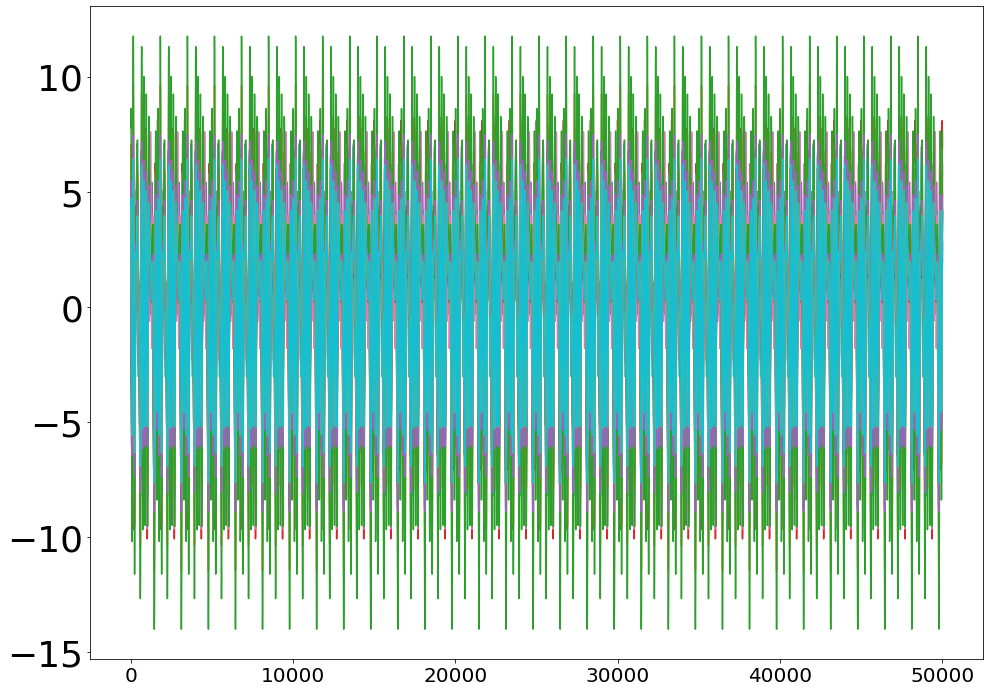

In [26]:
run_no =np.arange(0,no,1)
#np.random.shuffle(run_no)
a_b_l =[]
z_sig_10,tps_s,as_s = mock_injection_signal(2e8,lambda_val=10,height_sep=-15.5,x_sep=13.9,offset_y=+4.9,phase_shift="TF")

for i in tqdm(range(20)):
    print(i, run_no[i])
    if(i<10):
        alpha_scale_bkg = [1/(np.random.randint(1,10)*1e8) for x in range(13)]
        TF_phases_bkg = [0,0,0.65,0.49,1.5,1.5,1.5,1.5,1.5,1.5,1.5,1.5,1.5]    # [1.22,0.97,0.65,0.49,0.3,0.12,0.29,0.13,0.23,0.22,0.27,0.27,0.07] 
    elif(i>10): 
        alpha_scale_bkg = [1/(np.random.randint(1,10)*1e8)]*13
        TF_phases_bkg = [1.22,0.97,0.65,0.49,0.3,0.12,0.29,0.13,0.23,0.22,0.27,0.27,0.07] 
    elif(i==10): 
        alpha_scale_bkg = [1/(1.7e8)]*13
        TF_phases_bkg = [1.22,0.97,0.65,0.49,0.3,0.12,0.29,0.13,0.23,0.22,0.27,0.27,0.07] 
    z_bkg_10,tps_b,as_b,ap_b = mock_injection_bkg(alpha_scale_bkg=alpha_scale_bkg,lambda_val=10,height_sep=-15.5,x_sep=13.9,offset_y=+4.9,TF_phases_bkg = TF_phases_bkg)
    final_signal = z_sig_10 + z_bkg_10  
    plt.plot(final_signal)
    file_creator_rounding_uniform_random_noise(final_signal,in_file_paths,out_dir,direction=direction_in[i],run_no=run_no[i],max_file=1000)
    #metafile_creator(i)
    metafile_creator_bkg(i)
    a_b_l.append(alpha_scale_bkg)
np.save(out_dir+"run_no.npy",run_no)
#np.save(out_dir+"alpha_scale_in.npy",alpha_scale_in)
np.save(out_dir+"lambda_val_in.npy",lambda_val_in)
np.save(out_dir+"direction_in.npy",direction_in)
np.save(out_dir+"phase_shift_in.npy",phase_shift_in)
np.save(out_dir+"alpha_scale_bkg.npy",a_b_l)
